# Введение

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.


В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

# Описание данных

**name** - Название игры


**platform** - Платформа, на которую выпущена игра


**year_of_rlease** - Год выхода игры


**genre** - Жанр 


**na_sales, eu_sales, jp_sales, other_sales** - Продажи игры в Северной америке, Европе и остальном мире соответственно


**critic_score** - Оценка критиков


**user_score** - Оценка пользователей


**rating** - Присвоенный возрастной рейтинг

*Данные за 2016 год могут не быть полными*

# Ознакомление с данными

Начнем с импорта необходимых библиотек:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from matplotlib.pyplot import figure
import numpy as np
import warnings
from scipy import stats as st
warnings.filterwarnings("ignore")
matplotlib_axes_logger.setLevel('ERROR')

Откроем предоставленый датасет и изучим его в общем представлении:

In [2]:
data = pd.read_csv('/datasets/games.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Сразу можно отметить несколько моментов, которые потребуют исправления при предобработке данных:

1) Названия колонок должны будут приведены к нижнему регистру

2) **critic_score** должен быть приведен к типу данных integer, посколько их оценка дается целым числом из расчета 100 баллов

3) **year_of_release** должен быть приведен к типу данных integer, поскольку год - это целочисленное значение

4) **user_score** должен быть приведен к типу float, поскольку тип object не подойдет для последующих математических операций с ним

5) В датафрейме очень много пропусков. Наверняка найдутся и дубликаты. С этим тоже необходимо будет разобраться

На этом ознакомление с данными можно считать завершенным. Перейдем к их предобработке для последующего анализа.

# Предобработка данных

Приведем названия столбцов к нижнему регистру:

In [3]:
data = data.rename(str.lower, axis='columns')
data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Приведем указанные выше столбцы к правильному типу данных:

In [4]:
data[['critic_score', 'year_of_release']] = data[['critic_score', 'year_of_release']].astype('Int64')

Теперь выясним почему столбец **user_score** принял тип object. Посмотрим его значения:

In [5]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Вот оно! Значение **'tbd'** - строковое. To Be Determined (TBD) рейтинг пристваивают играм, которые имеют менее четырех ревью на сайте Metacritic. В нашем случае 

In [6]:
data['user_score'] = data['user_score'].replace('tbd', np.NaN)
data['user_score'] = data['user_score'].astype('float')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   Int64  
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: Int64(2), float64(5), object(4)
memory usage: 1.4+ MB


Теперь, когда все данные приведены к нужному типу, можно заняться удалением и заполнением пропусков. Я собираюсь удальить не более 5% строк от их общего числа в исходном датасете.

Еще раз оценим количество пропусков:

In [8]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

Выясню что за таинственные игры без названия и жанра:

Как оказалось это все заключено в двух строчках. Их мы можем спокойно удалить:

In [9]:
data = data[data['name'].notna()]

Оценим долю оставшихся пропусков в процентном выражении:

In [10]:
data.isna().sum() / len(data) * 100

name                0.000000
platform            0.000000
year_of_release     1.609526
genre               0.000000
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
critic_score       51.313349
user_score         54.586250
rating             40.471489
dtype: float64

Какие столбцы имеют пропуски?

**year_of_release** - год игры не может быть заполнен средним или медианным значением. Такие пропуски составляют примерно 1.6% от данных датафрейма. От них я избавлюсь. Это не должно сильно сказаться на итоговом анализе.

**critic_score, user_score** - такие данные тоже неправильно было бы заполнять медианным или средним значением, поскольку качество игры - это фактор, слабо поддающийся статистическому расчету. Тем более, когда пропуски составляют более половины от данных всего датафрейма. Возможно, эти игры старше сервиса Metacritic и в свое время они просто не оценивались. Двлее я проверю эту теорию.

**rating** - рейтинг не может быть заменен самым часто встречающимся или иным значением. Возможно игры без рейтинга предназначены для выпуска на те рынки, где такая маркировка не требуется или же были выпущены до создания агентства ESRB.


In [11]:
print('Процент игр без рейтинга, появившиеся до создания Metacritic:', round(len(data[data['year_of_release'] < 2000]) / data['user_score'].isna().sum() * 100, 2), '%')

Процент игр без рейтинга, появившиеся до создания Metacritic: 21.64 %


Теория не подтверждается. Таких игр одна из пяти. 

Пропуски в **critic_score, user_score** заполню индикаторным значением -1. Это позволит ужасным играм с рейтингом 0 остаться при анализе. 

Пропуски в **rating** заполню плашкой 'Not Rated'

In [12]:
data['critic_score'] = data['critic_score'].fillna(-1)
data['user_score'] = data['user_score'].fillna(-1)
data['rating'] = data['rating'].fillna('Not Rated')
data = data[data['year_of_release'].notna()]
round(data.isna().sum() / len(data) * 100, 1)

name               0.0
platform           0.0
year_of_release    0.0
genre              0.0
na_sales           0.0
eu_sales           0.0
jp_sales           0.0
other_sales        0.0
critic_score       0.0
user_score         0.0
rating             0.0
dtype: float64

Создам отдельный столбец с суммарными продажами игры во всех регионах. Это упростит последующий анализ.

In [13]:
data['world_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

На данном этапе предобработку данных можно считать завершенной. Мы избавились от пропусков в годах выпуска, добавили индикаторые рейтинговые значения там, где это нужно и добавили удобный столбец с мировыми продажами игр. Потеря в данных составила 1.6% строк, что является допустимым результатом.

# Исследовательский анализ данных

Для начала оценим динамику выпуска игр во всем мире:

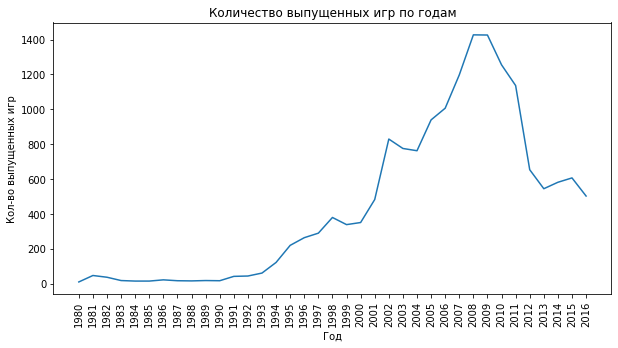

In [14]:
ax = data.pivot_table(index = 'year_of_release', 
                 aggfunc = 'count', 
                 values = 'rating').plot(kind = 'line', 
                                        title = 'Количество выпущенных игр по годам',
                                        xlabel = 'Год',
                                        ylabel = 'Кол-во выпущенных игр',
                                        legend = False,
                                        figsize = (10, 5),
                                        xticks = [i for i in range(1980, 2017)],
                                        rot = 90)
ax;

Что можно увидеть на этом графике? 

Во-первых, подъём в районе 1993 года. Тогда intel начали производить массовые и дешевые процессоры 468-й серии , что позволило значительно скоратить стоимость компьютеров, а также повысило их привлекательность для разработчиков видеоигр, которые на тот момент почти все бли на консолях.

Во-вторых, скачок в 2001 году. Это был пик дистрибьюции контента через CD носители. Релиз Playstaytion 2 и развитие компьютерного железа позволили открыть новые горизонты в вопросе качества видеоигр. Это ривело к интересу к ним со стороны массового потребителя.

В-третьих - еще один скачок в 2008-2010 годах. Золотой век игровой индустрии. Обилие новых игровых серий, которые впоследствие станут сверхпопулярными, битва за пользователей среди двух компаний-производителей консолей 8 поколения и т.п...

В-четвертых, спад в 2011. Развитие социальных сетей и мобильного рынка видеоигр вызвало сильный отток игроков с классических платформ (консолей и ПК). 

In [15]:
data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,world_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.0,Not Rated,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,-1.0,Not Rated,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,-1,-1.0,Not Rated,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,-1,-1.0,Not Rated,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,-1,-1.0,Not Rated,0.01
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,-1,-1.0,Not Rated,0.01


Теперь оценим положение отдельных платформ в ретроспективе:

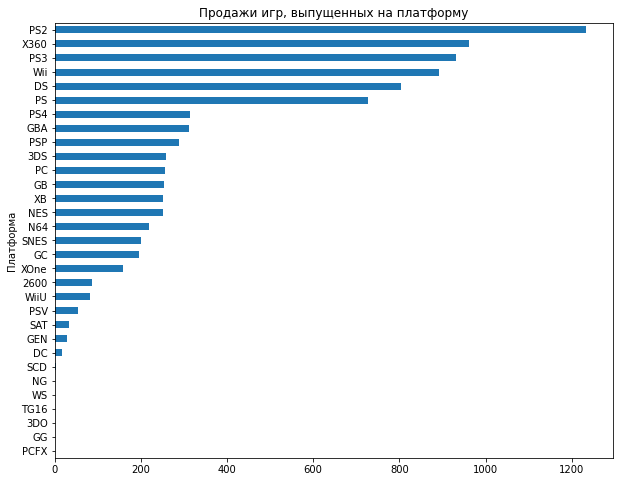

In [16]:
quaso = data.pivot_table(index = 'platform', 
                 aggfunc = 'sum', 
                 values = 'world_sales').sort_values(by = 'world_sales')
quaso.plot(kind = 'barh', 
           figsize = (10, 8), 
           legend = False, 
           title = 'Продажи игр, выпущенных на платформу', 
           xlabel = 'Платформа');

Самые успешные - PS2 и XBox360 - лидеры консольного рынка в рамках своих поколений.

Рассмотрим те же данные, но в динамике по годам:

In [17]:
inga = list(quaso.tail(5).index)

In [18]:
ara = data.pivot_table(index = 'year_of_release', 
                       columns = 'platform', 
                       values = 'world_sales', 
                       aggfunc = 'sum')

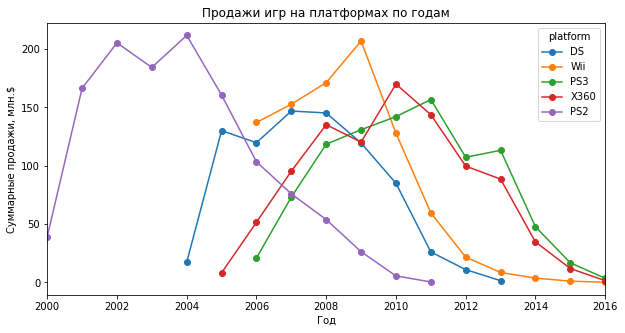

In [19]:
showus = ara[inga].plot(figsize = (10, 5), style = 'o-', 
                        title = 'Продажи игр на платформах по годам',
                       xlabel = 'Год',
                       ylabel = 'Суммарные продажи, млн.$',
                       xlim = (2000, 2016));

Я оставил на этом графике топ-10 платформ по продажам за все время. Что можно вынести из этого графика?

В среднем каждая крупная успешная платформа имеет срок жизни в 8-10 лет. Среди игровых консолей этот срок принято считать поколением. Более того, на графике можно видеть, что "бугры" поднимаются и падают практически одновременно. В рамках одного "бугорка" можно проследить динамику конкуренции нескольких платформ в рамках одного поколения (PS3 и XBox 360).

Возьмем данные за соответствующий актуальный период. Им я буду считать период с 2013 по 2015 год. Эти года идут после "золотого времени" видеоигр. Более того, они несут в себе определенный тренд у квяданию и коренному изменению классической видеоигровой индустрии. По ним мы сможем оценить и спрогнозировать изменение отрасли к 2017 году.

In [20]:
olddata = data
data = data.query('year_of_release >= 2013')

In [21]:
quaso = data.pivot_table(index = 'platform', 
                 aggfunc = 'sum', 
                 values = 'world_sales').sort_values(by = 'world_sales')
inga = list(quaso.tail(5).index)

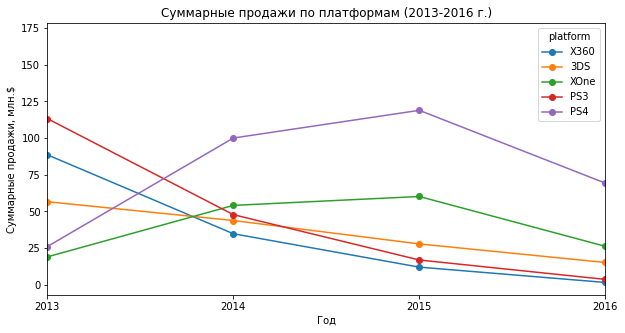

In [22]:
showus = ara[inga].plot(figsize = (10, 5), 
                        style = 'o-', 
                        xlim = (2013, 2016),
                       title = 'Суммарные продажи по платформам (2013-2016 г.)',
                       xlabel = 'Год',
                       ylabel = 'Суммарные продажи, млн.$',
                       xticks = [i for i in range(2013, 2017)]);

На конец 2016 лидируют две консоли от противостоящих студий гигантов: Sony и Microsoft. В прошлых годах прослеживается такая же тененция.Вырвались в лидеры они в 2014 году, почти сразу после выпуска как представители нового поколения приставок. Думаю, что можно сделать вывод о том, что лидирующие позиции рынка продолжит занимать большая тройка. 

В последние несколько лет лидирует Sony Playstaytion. С отрывом. Основную ставку будем делать на неё.

Теперь построю **boxplot** по глобальным продажам игр в разбивке по платформам:

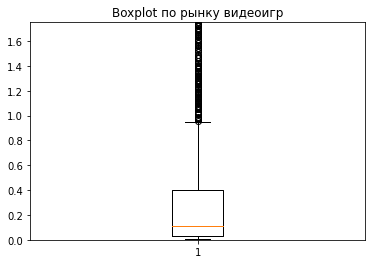

In [23]:
plt.boxplot(data['world_sales'])
plt.ylim(0, 1.75)
plt.title('Boxplot по рынку видеоигр');

В среднем игры собирают кассу в 1 300 000 долларов. Но эта цифра получена благодаря хитам ААА класса. Медианное значение сильно скромнее - 200 000 долларов. 

Теперь посмотрим как зарабытвают игры на различных платформах:

In [24]:
arsik = data.pivot_table(index = 'name', columns = 'platform', values = 'world_sales')

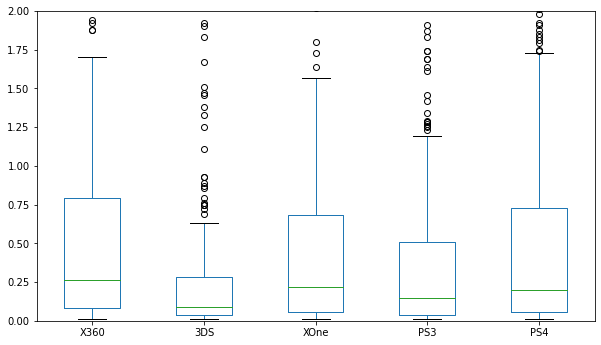

In [25]:
arsik[inga].plot(kind = 'box', ylim = (0,2), figsize = (10, 5.7));

Выводы:

- Медиана по значениям на самых популярных платформах составляет около 0.1 - 0.3 млн. долларов. 
- Значение, которое для многих компаний определяется как аномально большое лежит за пределом 1.75 миллионов долларов
- Значительно из ряда выбивается Nintendo 3DS. Скорее всего на неё выходят слишком нишевые игры, интересные ограниченной группе игроков. Этим можно объяснить её неспособность конкурировать даже с прошлыми поколениями японских и американских конкурентов.

Теперь рассмотрим как влияют на продажи игры отзывы в рамках одной конкретной популярной платформы. Я выбрал PS4.

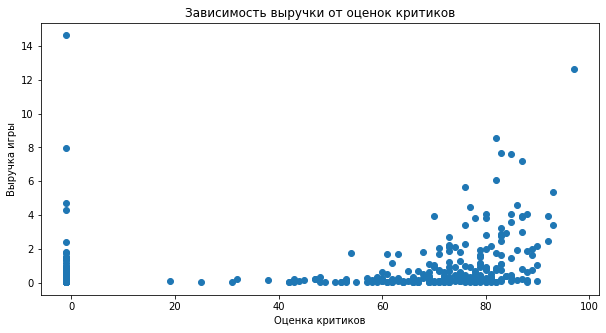

In [26]:
plt.figure(figsize=(10, 5))
ps4dat = data[data['platform'] == 'PS4']
plt.scatter(ps4dat['critic_score'], ps4dat['world_sales']);
plt.xlabel('Оценка критиков')
plt.ylabel('Выручка игры')
plt.title('Зависимость выручки от оценок критиков');

Действительно, корерляция четко видна. Чем выше оценки критиков - тем лучше игра продается.

Что же до простых игроков?

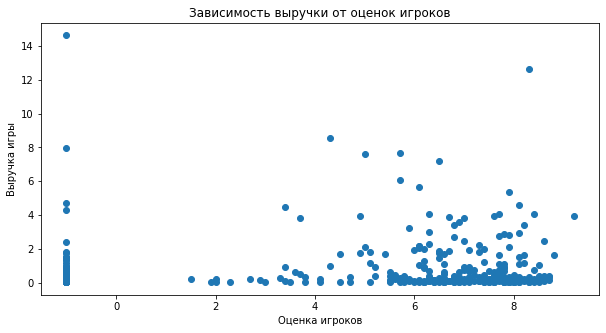

In [27]:
plt.figure(figsize=(10, 5))
ps4dat = data[data['platform'] == 'PS4']
plt.scatter(ps4dat['user_score'], ps4dat['world_sales']);
plt.xlabel('Оценка игроков')
plt.ylabel('Выручка игры')
plt.title('Зависимость выручки от оценок игроков');

Ситуация менее однозначная. Все же присутствуют аномально хорошо продавшиеся игры, получившие низкий балл, однако общая картина правдоподобна и совпадет с подобной среди критиков.

Такие выбросы могут быть вызваны спорными решениями разработчиков (и ревью-бомбинг как их следствие), обман пользователей несбыточными обещаниями и т.п...

Однако, общий **вывод** прост: чем лучше об игре отзываются критики и игроки - тем она успешнее в финансовом плане

Аналогичные ли выводы мы можем сделать касаемо прочих платформ? Построим матрицу корреляции, чтобы выяснить это:

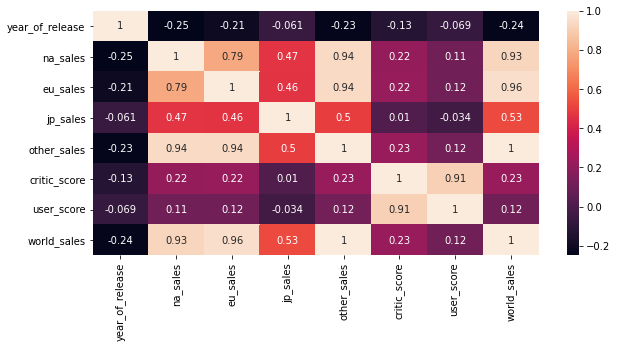

In [28]:
plt.figure(figsize=(10,4.5))
sns.heatmap(ps4dat.corr(), annot = True);

Оставлю только нужное:

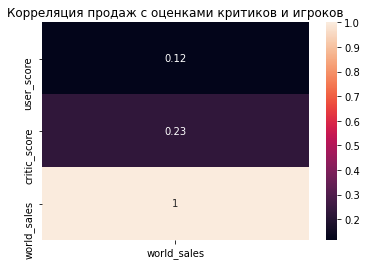

In [29]:
ax = plt.axes()
ps4ft = ps4dat[['world_sales', 'user_score', 'critic_score']]
sns.heatmap(ps4ft.corr()[['world_sales']].sort_values(by = 'world_sales'), annot = True)
ax.set_title('Корреляция продаж с оценками критиков и игроков');

Как вывяснилось - оценки критиков лучше показывают финансовую успешность игры. Проведем те же действия и для прочих:

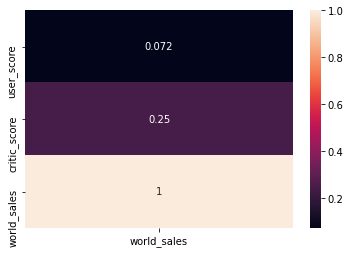

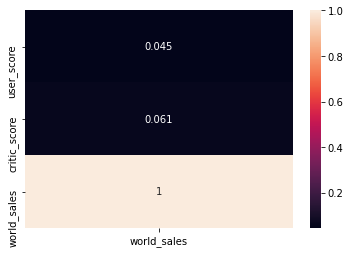

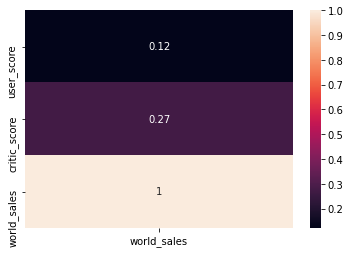

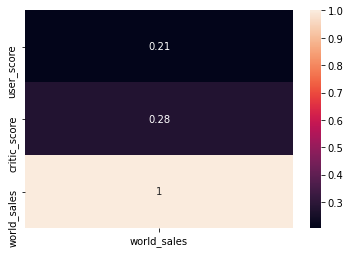

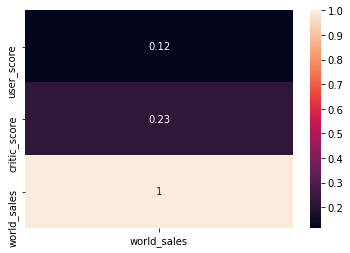

In [30]:
for entry in inga:
    plt.figure()
    dat = data[data['platform'] == entry]
    datclr = dat[['world_sales', 'user_score', 'critic_score']]
    sns.heatmap(datclr.corr()[['world_sales']].sort_values(by = 'world_sales'), annot = True);

Согласно данным по корреляции прочих платформ можно сделать несколько выводов:

- Корреляция между выручкой и оценками на популярных платформах (PS2, PC, XBox360 etc.) совпадает с общими данными по всему датафрейму.
- Аномально себя ведут Wii и DS. Эти консоли в основном покупают для приобретения игр Nintendo. Они нравятся многочисленным азиатам и их можно назвать family friendly. С точки зрения критиков такие игры не очень ценны, однако сверхпопулярны у массовой аудитории.
- PS4 и XBox выпускают множество дорогостоящих рекламных эксклюзиных проектов на свои платформы. Такие игры, как правило, любимы критиками и очень успешно продают не только себя, нои  платформу-носитель.

В довершение оценим распределение игр по жанрам:

In [31]:
data['world_sales'] = data['world_sales']*1000

In [32]:
data['world_sales2'] = data['world_sales']

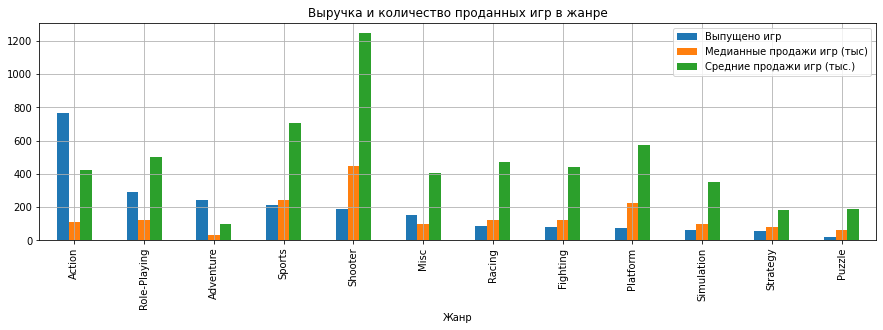

In [33]:
fig, ax = plt.subplots()
tts = data.groupby(by = 'genre').agg({'name': 'count', 'world_sales': 'median', 'world_sales2': 'mean'}).sort_values(by='name',ascending=False)
tts.plot(kind = 'bar', figsize = (15, 4), 
         grid = True,
        title = 'Выручка и количество проданных игр в жанре',
        xlabel = 'Жанр',
        ax = ax);
ax.legend(["Выпущено игр", "Медианные продажи игр (тыс)", "Средние продажи игр (тыс.)"]);

- Сделаем выводы из построенной столбчатой диаграммы:

- Самые выгодные в производстве - **шутеры и спортивные игры**

- Рынок переполнен играми в жанре **action**. Возможно их среднее качество достаточно низко, ведь медианное значение продаж ЗНАЧИТЕЛЬНО отличается от среднего.

- Очень плохо продаются игры в жанре **Puzzle, Adventure**

- Скорее всего представленная тенденция срхранится. Ставку при разработке рекламных кампаний следует делать на шутеры и спортивные игры.

Стоимт иметь ввиду, что хоть на паззлы и адвенчуры не имеется приемлемого спроса - они достаточно дёшевы и быстры в производстве. Разработка такой игры (даже в случае её провала) не станет большим ударом по студии разработчику.

# Типичный портрет потребителя для каждого из регионов

Составим портрет типичного потребителя для каждого из трех основных регионов (jp, eu, na). Для этого опишем ряд характеристик:

1) Самые популярные платформы

2) Самые популярные жанры

3) Игры с каким возрастным рейтингом пользуются популярностью в регионе

In [34]:
color_dict = {'na_sales': 'blue', 'eu_sales': 'red', 'jp_sales': 'green'}
title_dict = {'na_sales': 'Северная Америка', 'eu_sales': 'Европа', 'jp_sales': 'Япония'}
def check_machine(characteristic, region, ax):
    pivot = data.groupby(characteristic).agg({region: 'sum'}).sort_values(by=region, ascending=False)[:5]
    plot = pivot.plot(kind='bar', ec='black', color = color_dict[region], 
                   fontsize=18, rot=20, ax=axes[ax], grid = True, title = title_dict[region])

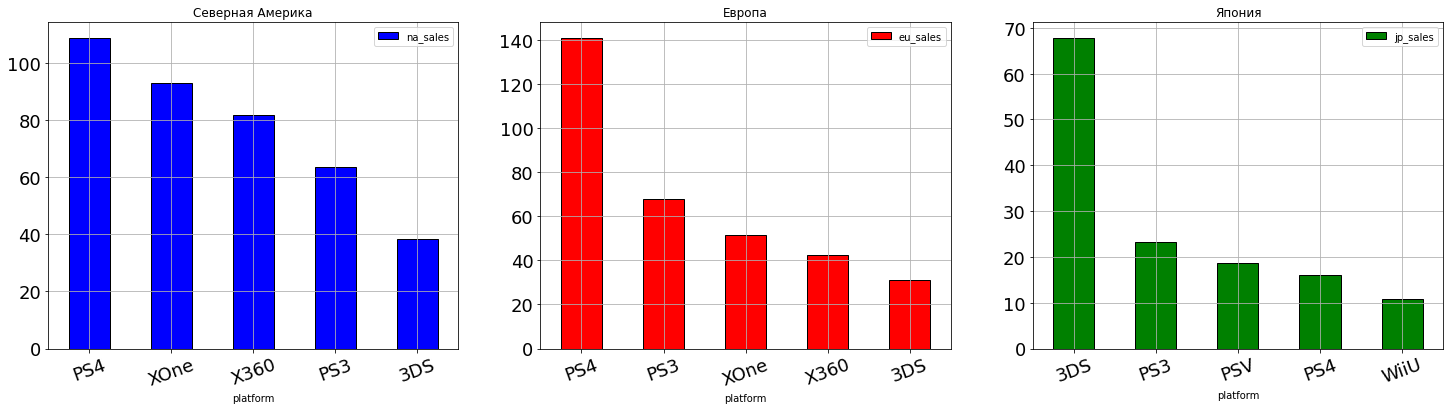

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))
check_machine('platform', 'na_sales', 0)
check_machine('platform', 'eu_sales', 1)
check_machine('platform', 'jp_sales', 2)

Теперь оценим жанры

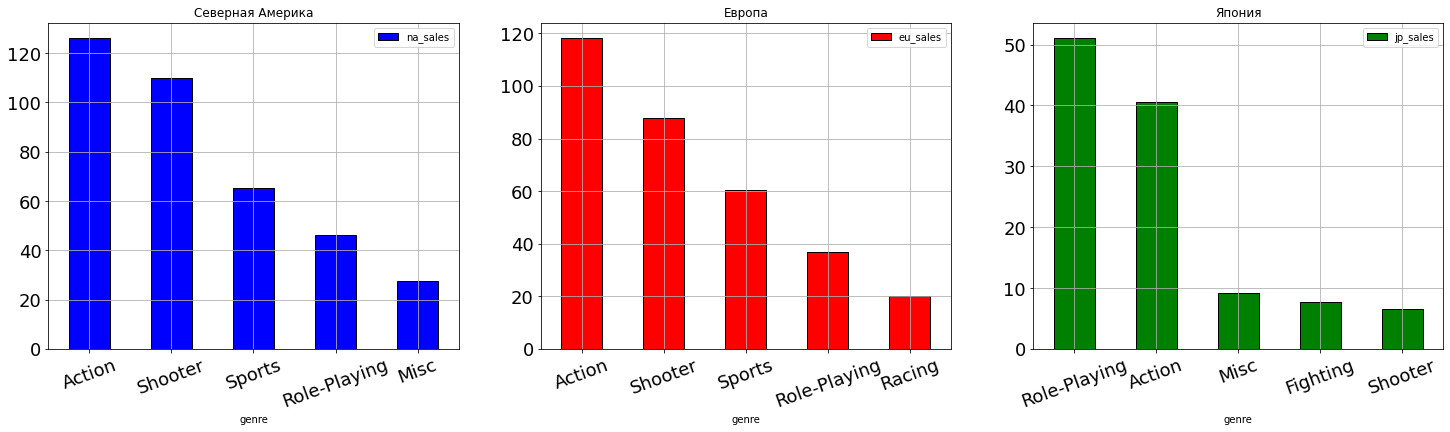

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))

check_machine('genre', 'na_sales', 0)
check_machine('genre', 'eu_sales', 1)
check_machine('genre', 'jp_sales', 2)

И оценим возрастные рейтинги игр:

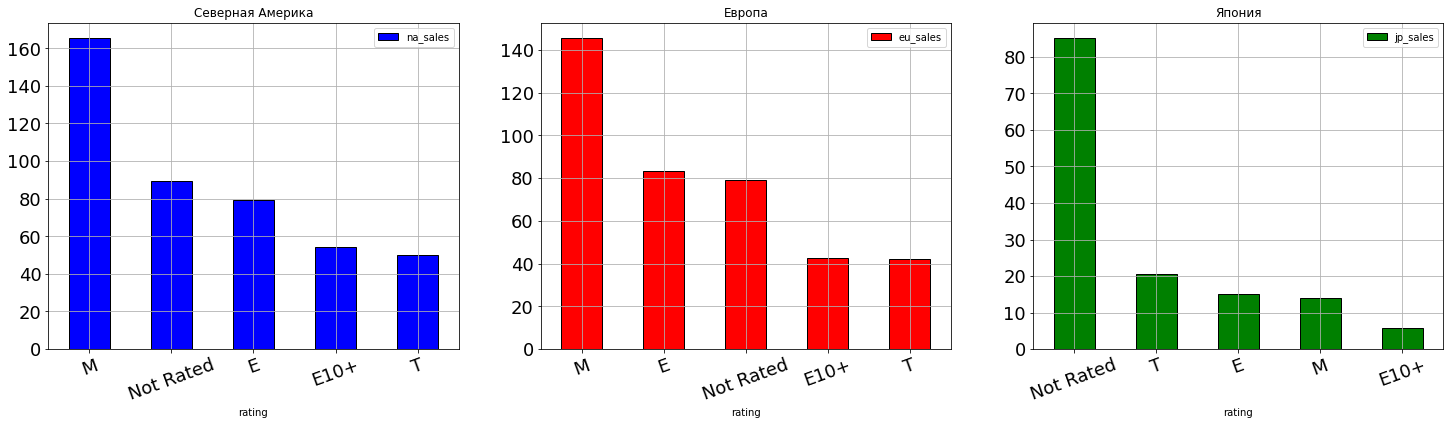

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))

check_machine('rating', 'na_sales', 0)
check_machine('rating', 'eu_sales', 1)
check_machine('rating', 'jp_sales', 2)

**Итак, составим типичные портреты покупателей в регионах:**

**ЕВРОПА**: Игрок использует новейшую или устаревшую Sony Playstaytion. На ней он играет в экшены, шутеры и спортивные игры с рейтиеном "Для взрослых", реже - "Для всех".

**СЕВЕРНАЯ АМЕРИКА**: Игрок использует новейшую приставку от Sony или Microsoft для игры в экшены, шутеры и спортивные игры. В его библиотеке больше игр с рейтингов "Для взрослых".

**ЯПОНИЯ**: Игрок предпочитает отечественную Nintendo 3DS для игры в ролевые игры. Чаще всего это игры от японцев и для японцев, а потому не оценены ESRB.

# Проверим некоторые гипотезы

**Гипотеза №1**: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

H0: Средний пользовательский рейтинг XBox One = средний пользовательский рейтинг PC

H1: Средний пользовательский рейтинг XBox One != средний пользовательский рейтинг PC

alpha приму за **0.05** для этой и последующих гипотез. 

In [38]:
alpha = 0.05

In [39]:
x1r = data[(data['platform'] == 'XOne') & (data['user_score'] > 0)]['user_score']
pcr = data[(data['platform'] == 'PC') & (data['user_score'] > 0)]['user_score']

results = st.ttest_ind(x1r, pcr)
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.14012658403611647
Не получилось отвергнуть нулевую гипотезу


 Статистически значимой разницы между средним пользователемским рейтингом Xbox One и PC нет

**Гипотеза №2**: Средние пользовательские рейтинги жанров Action и Sports разные

H0: Средний рейтинг игр жанра Action = средний рейтинг игр жанра Sports

H1: Средний рейтинг игр жанра Action != средний рейтинг игр жанра Sports

In [40]:
ar = data[(data['genre'] == 'Action') & (data['user_score'] > 0)]['user_score']
sr = data[(data['genre'] == 'Sports') & (data['user_score'] > 0)]['user_score']

results = st.ttest_ind(ar, sr)
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.0517832389140023e-27
Отвергаем нулевую гипотезу


Получается, что средние пользовательские рейтинги игр в жанре Sports и Action не одинаковые. Выясним у кого и на сколько больше:

In [41]:
if sr.mean() > ar.mean():
    print('Разница между оценками в жанрах',round(abs(ar.mean() - sr.mean()), 2), 'в пользу Sports по мнению игроков')
else:
    print('Разница между оценками в жанрах',round(abs(ar.mean() - sr.mean()), 2), 'в пользу Action по мнению игроков')

Разница между оценками в жанрах 1.6 в пользу Action по мнению игроков


# Вывод

По итогам данной работы была проведена предобработка данных, удалены некорректные данные, заполнены имеющиеся пропуски. Данные содержат всю необходимую информацию, чтобы оценить успешность игры и понять на что делать ставку при планировании рекламных кампаний в дальнейшем.

Динамика на рынке компьютерныхигр свидетельствует о том, что отрасль очень медленно, но умирает. Интерес к играм падает, их выпускается все меньше и меньше. Рынок захватывается новыми платформами и привычным мастадонтам (Sony, Microsoft, Nintendo) на нем уже не так хорошо себя чувствуется. 

Мы выяснили, что в среднем одно поколение видеоигровых платформ "живет" около десятка лет. Затем его смещают платформы нового поколения от иных и собственного производителя. Поэтому не стоит делать большую ставку на игры на те платформы, которым уже 8-9  лет.

Помимо всего прочего, мы доказали, что корреляция между оценками игроков и критиков и успешностью продаж игры существует. Корреляция с оценками критиков более сильная, а потому ставку в рекламных акциях стоит делать именно на те игры, которые пришлись по душе обозревателям (особенно это касается консольного сегмента).

Самые выгодные с точки зрения бизнеса - Экшен, Спортивные и Приключенческие игры. Небольшое их количество компенсируется великим интересом со стороны потребителей. Наименее интересные нам, как бизнесу, жанры - это пазлы и платформеры.

Также мы составили портреты типичных потребителей в разных регионах и оценили их интересы: 
- При расширении бизнеса на запрадном рынке стоит отдавать предпочтение играм для всех возрастов в популярных жанрах: спортивные, приключенческие, экшены. Западные игроки предпочитают играть на популярнейших видеоигровых приставках (Playstaytion и XBox)
- При расширении бизнеса на запрадном рынке стоит отдавать предпочтение играм в жанре RPG, которые выходят на японских платформах (Nintendo, Sega). Было отмечено, что японцы не склонны покупать игры, доступные для всех возрастов

Были проверены гипотезы. По итогам проверки можно сформулировать следующие тезисы:
- Средний пользовательский рейтинг XBox One равен среднему пользовательскому рейтингу PC.
- Средние пользовательские рейтинги игр в жанре Sports и Action не одинаковые. Action-игры набирают в среднем на 1.6 балла больше.